#### **Example notebook for BCI Fitts task with click decoding**

We use our usual closed-loop simulator but with a couple innovations:
- an orthogonal neural dimension (to velocity) encoding the click signal
- a click decoder that reads out click-related activity (logistic regression)
- a drift-diffusion click signal model where:

    $C_t = C_{t-1} + \alpha * evidence  + N(decay, \sigma^{2})$
    

The evidence term is a nonlinear weighting of the distance to target, given by a logistic decay function:

    $evidence_{t} = 1 / (1 + e^{(distance - 0.07) * 20)}$

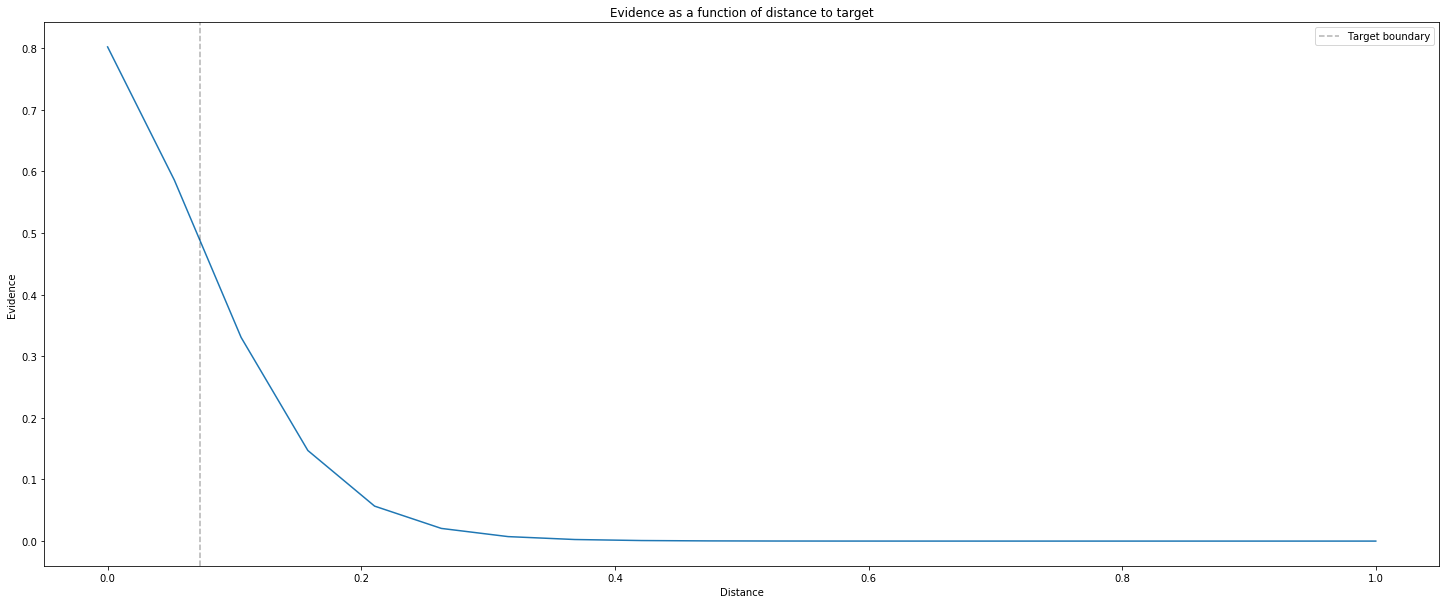

In [38]:
# let's plot the evidence function
x = np.linspace(0, 1, 20)
y = 1 / (1 + np.exp(1 * (x - 0.07) * 20)) 

plt.plot(x, y)
plt.axvline(0.0725, linestyle = '--', color = 'k', alpha  = 0.3, label = 'Target boundary')
plt.title('Evidence as a function of distance to target')
plt.xlabel('Distance')
plt.ylabel('Evidence')
plt.legend()

In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from simulation_utils import * 
from stabilizer_utils import *
from simulation import *


# for a reproducible result
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to 1 (norm of the column is 1). '''

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

initialTuning  = generateUnits(n_units = nUnits, SNR = SNR)

calVelocity    = np.random.normal(size = (nTrainingSteps, 2))
calNeural      = calVelocity.dot(initialTuning[:,1:].T)  + initialTuning[:, 0].T;  # FR = <velocity, PD> + baseline
calNeural      = calNeural + np.random.normal(size = calNeural.shape) * 0.3      # add gaussian noise

lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  1.1666666666666665


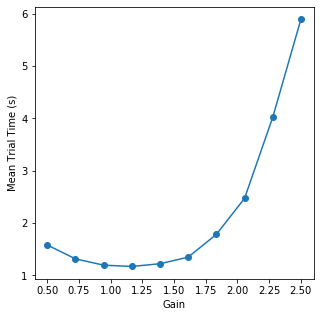

In [4]:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)


# Do a quick sweep of cursor gains to find the optimal one for this task:

import matplotlib.pyplot as plt 
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
nSimSteps    = 50000
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

plt.figure()
plt.plot(possibleGain, meanTTT, '-o')
plt.xlabel('Gain')
plt.ylabel('Mean Trial Time (s)')

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)

In [29]:
# now generate some simulated data with optimal gain:

posTraj, posErr_est, velTraj, rawDecTraj, clickMagTraj, clickTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts_click(initialTuning, 0, D, alpha, beta, nDelaySteps, delT, nSimSteps, return_PosErr = True)

dist         = np.linalg.norm(posTraj - targTraj, axis = 1)
est_dist     = np.linalg.norm(posErr_est, axis = 1)

Text(0.5, 1.0, 'Click signal magnitude across time')

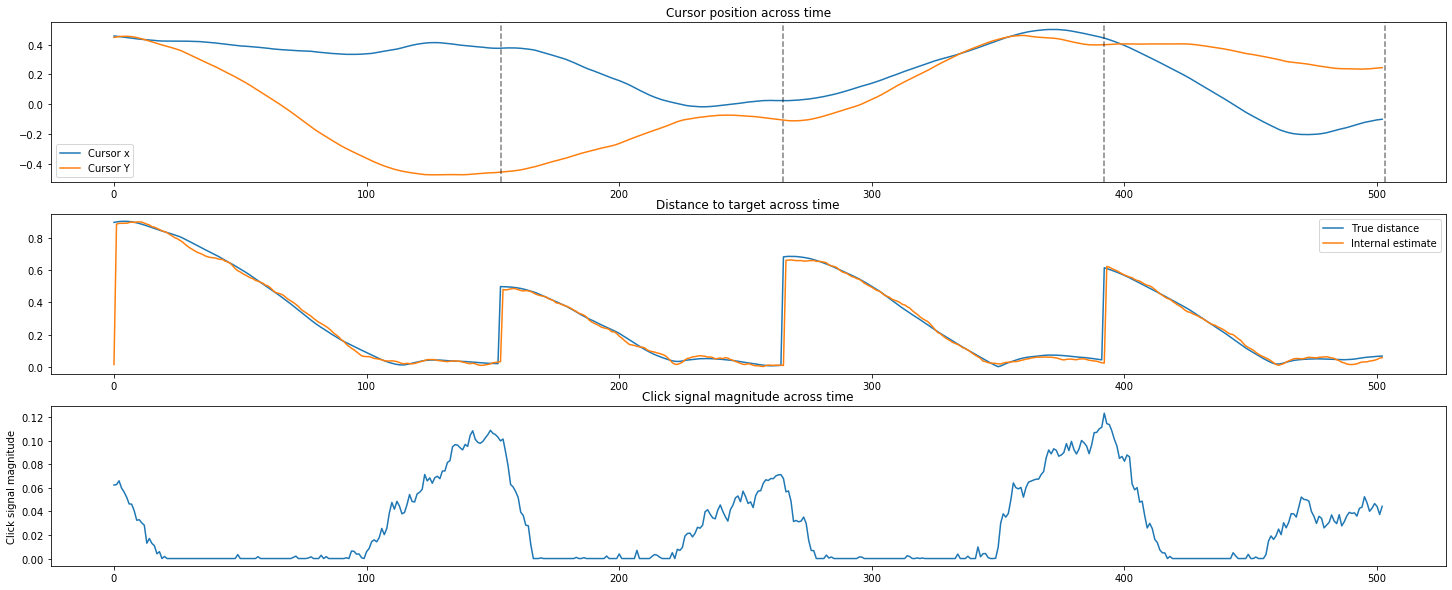

In [30]:
figSize(10, 25)

i      = 5  # starting trial index
n_trls = 4  # number of consecutive trials to plot 

start = trialStart[i]
stop  = trialStart[i + n_trls]

plt.subplot(3, 1, 1)
plt.title('')
plt.plot(posTraj[start:stop, :])
for j in range(1, n_trls + 1):
    plt.axvline(trialStart[i + j] - start,  color = 'k', linestyle = '--', alpha = 0.5)
plt.legend(['Cursor x', 'Cursor Y'])
plt.title('Cursor position across time', fontsize = 12)
#plt.axvline()

plt.subplot(3, 1, 2)
plt.plot(dist[start:stop], label = 'True distance')
plt.plot(est_dist[start:stop], label = 'Internal estimate')
plt.legend()
plt.title('Distance to target across time', fontsize = 12)

plt.subplot(3, 1, 3)
plt.plot(clickMagTraj[start:stop])
plt.ylabel('Click signal magnitude')
plt.title('Click signal magnitude across time')